<h1>GoJek App Reviewer</h1>
<b>Yeremia Maydinata Narana || 5026221068</b>

So this is my first time doing EDA and NLP, so please be kind. I will try to explain every step that I do. So let's get started.

<h2>#1 Scrapping Data</h2>  
Scrapping data from Google Play Store using <b>google-play-scraper</b> library.

In [1]:
!pip install google_play_scraper -q
!pip install textblob -q
!pip install seaborn -q


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import seaborn styles explicitly
import seaborn as sns
# Apply the seaborn style before creating plots
sns.set_style("whitegrid")  # This line sets the Seaborn style

plt.rcParams["figure.figsize"] = (15,10)

In [3]:
#Android App Gojek from Google Play at
#https://play.google.com/store/apps/details?id=com.gojek.app
#The apps ID found in the link after id=com.gojek.app

from google_play_scraper import app, Sort, reviews_all

gojek_reviews = reviews_all(
    'com.gojek.app',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [4]:
df_gjkrev = pd.DataFrame(np.array(gojek_reviews),columns=['content'])
df_gjkrev = df_gjkrev.join(pd.DataFrame(df_gjkrev.pop('content').tolist()))

In [5]:
df_gjkrev
df_gjkrev.info()
df_gjkrev['score'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226169 entries, 0 to 226168
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              226169 non-null  object        
 1   userName              226169 non-null  object        
 2   userImage             226169 non-null  object        
 3   content               226134 non-null  object        
 4   score                 226169 non-null  int64         
 5   thumbsUpCount         226169 non-null  int64         
 6   reviewCreatedVersion  193538 non-null  object        
 7   at                    226169 non-null  datetime64[ns]
 8   replyContent          35031 non-null   object        
 9   repliedAt             35031 non-null   datetime64[ns]
 10  appVersion            193538 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 19.0+ MB


score
5    123239
1     51072
4     21973
3     15510
2     14375
Name: count, dtype: int64

In [6]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_gjkrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

content  score  \
0       update review 22 Sept 2025 : paska udpate mala...      1   
1                                                      ok      5   
2       route yg dipilih dibuat jauh Dan muter muter, ...      2   
3       Bug: Audio become mono upon answering the driv...      1   
4                                   Terbantu Terima kasih      5   
...                                                   ...    ...   
226164                                      Love this app      5   
226165                              Akhirnya keluar juga!      5   
226166                                            Finally      5   
226167                                            Helpful      4   
226168                                     Usefull banget      5   

        thumbsUpCount reviewCreatedVersion                  at  \
0                   0               5.14.2 2025-09-22 11:02:15   
1                   0               5.31.2 2025-09-22 10:49:02   
2                   0                 None 2025-09-22 09:25:07   
3                   0               5.32.1 2025-09-22 09:04:29   
4                   0               5.30.1 2025-09-22 08:47:54   
...               ...                  ...                 ...   
226164              0                1.0.1 2014-12-31 04:11:06   
226165              0                1.0.1 2014-12-24 22:20:26   
226166              0                1.0.1 2014-12-23 12:04:16   
226167              0                 None 2014-12-20 23:41:52   
226168              1                 None 2014-12-19 22:00:21   

                                             replyContent           repliedAt  
0       Hai Kak Danardono, mohon maaf atas ketidaknyam... 2025-09-22 15:09:25  
1                                                    None                 NaT  
2       Mohon maaf atas ketidaknyamanannya, Kak Sylvia... 2025-09-22 15:06:18  
3       Hi Adim, we’re sorry for the inconvenience. Pl... 2025-09-22 10:42:03  
4                                                    None                 NaT  
...                                                   ...                 ...  
226164                                               None                 NaT  
226165                                               None                 NaT  
226166                                               None                 NaT  
226167                                               None                 NaT  
226168                                               None                 NaT  

[226169 rows x 7 columns]

<h2>#2 Preprocessing Data</h2> 

<b>Sentiment before Preprocessing</b>

In [7]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_gjkrev['sentiment_rating'] = df_gjkrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [8]:
from textblob import TextBlob
df_gjkrev['sentiment_polarity'] = df_gjkrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_gjkrev['sentiment_subjective'] = df_gjkrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

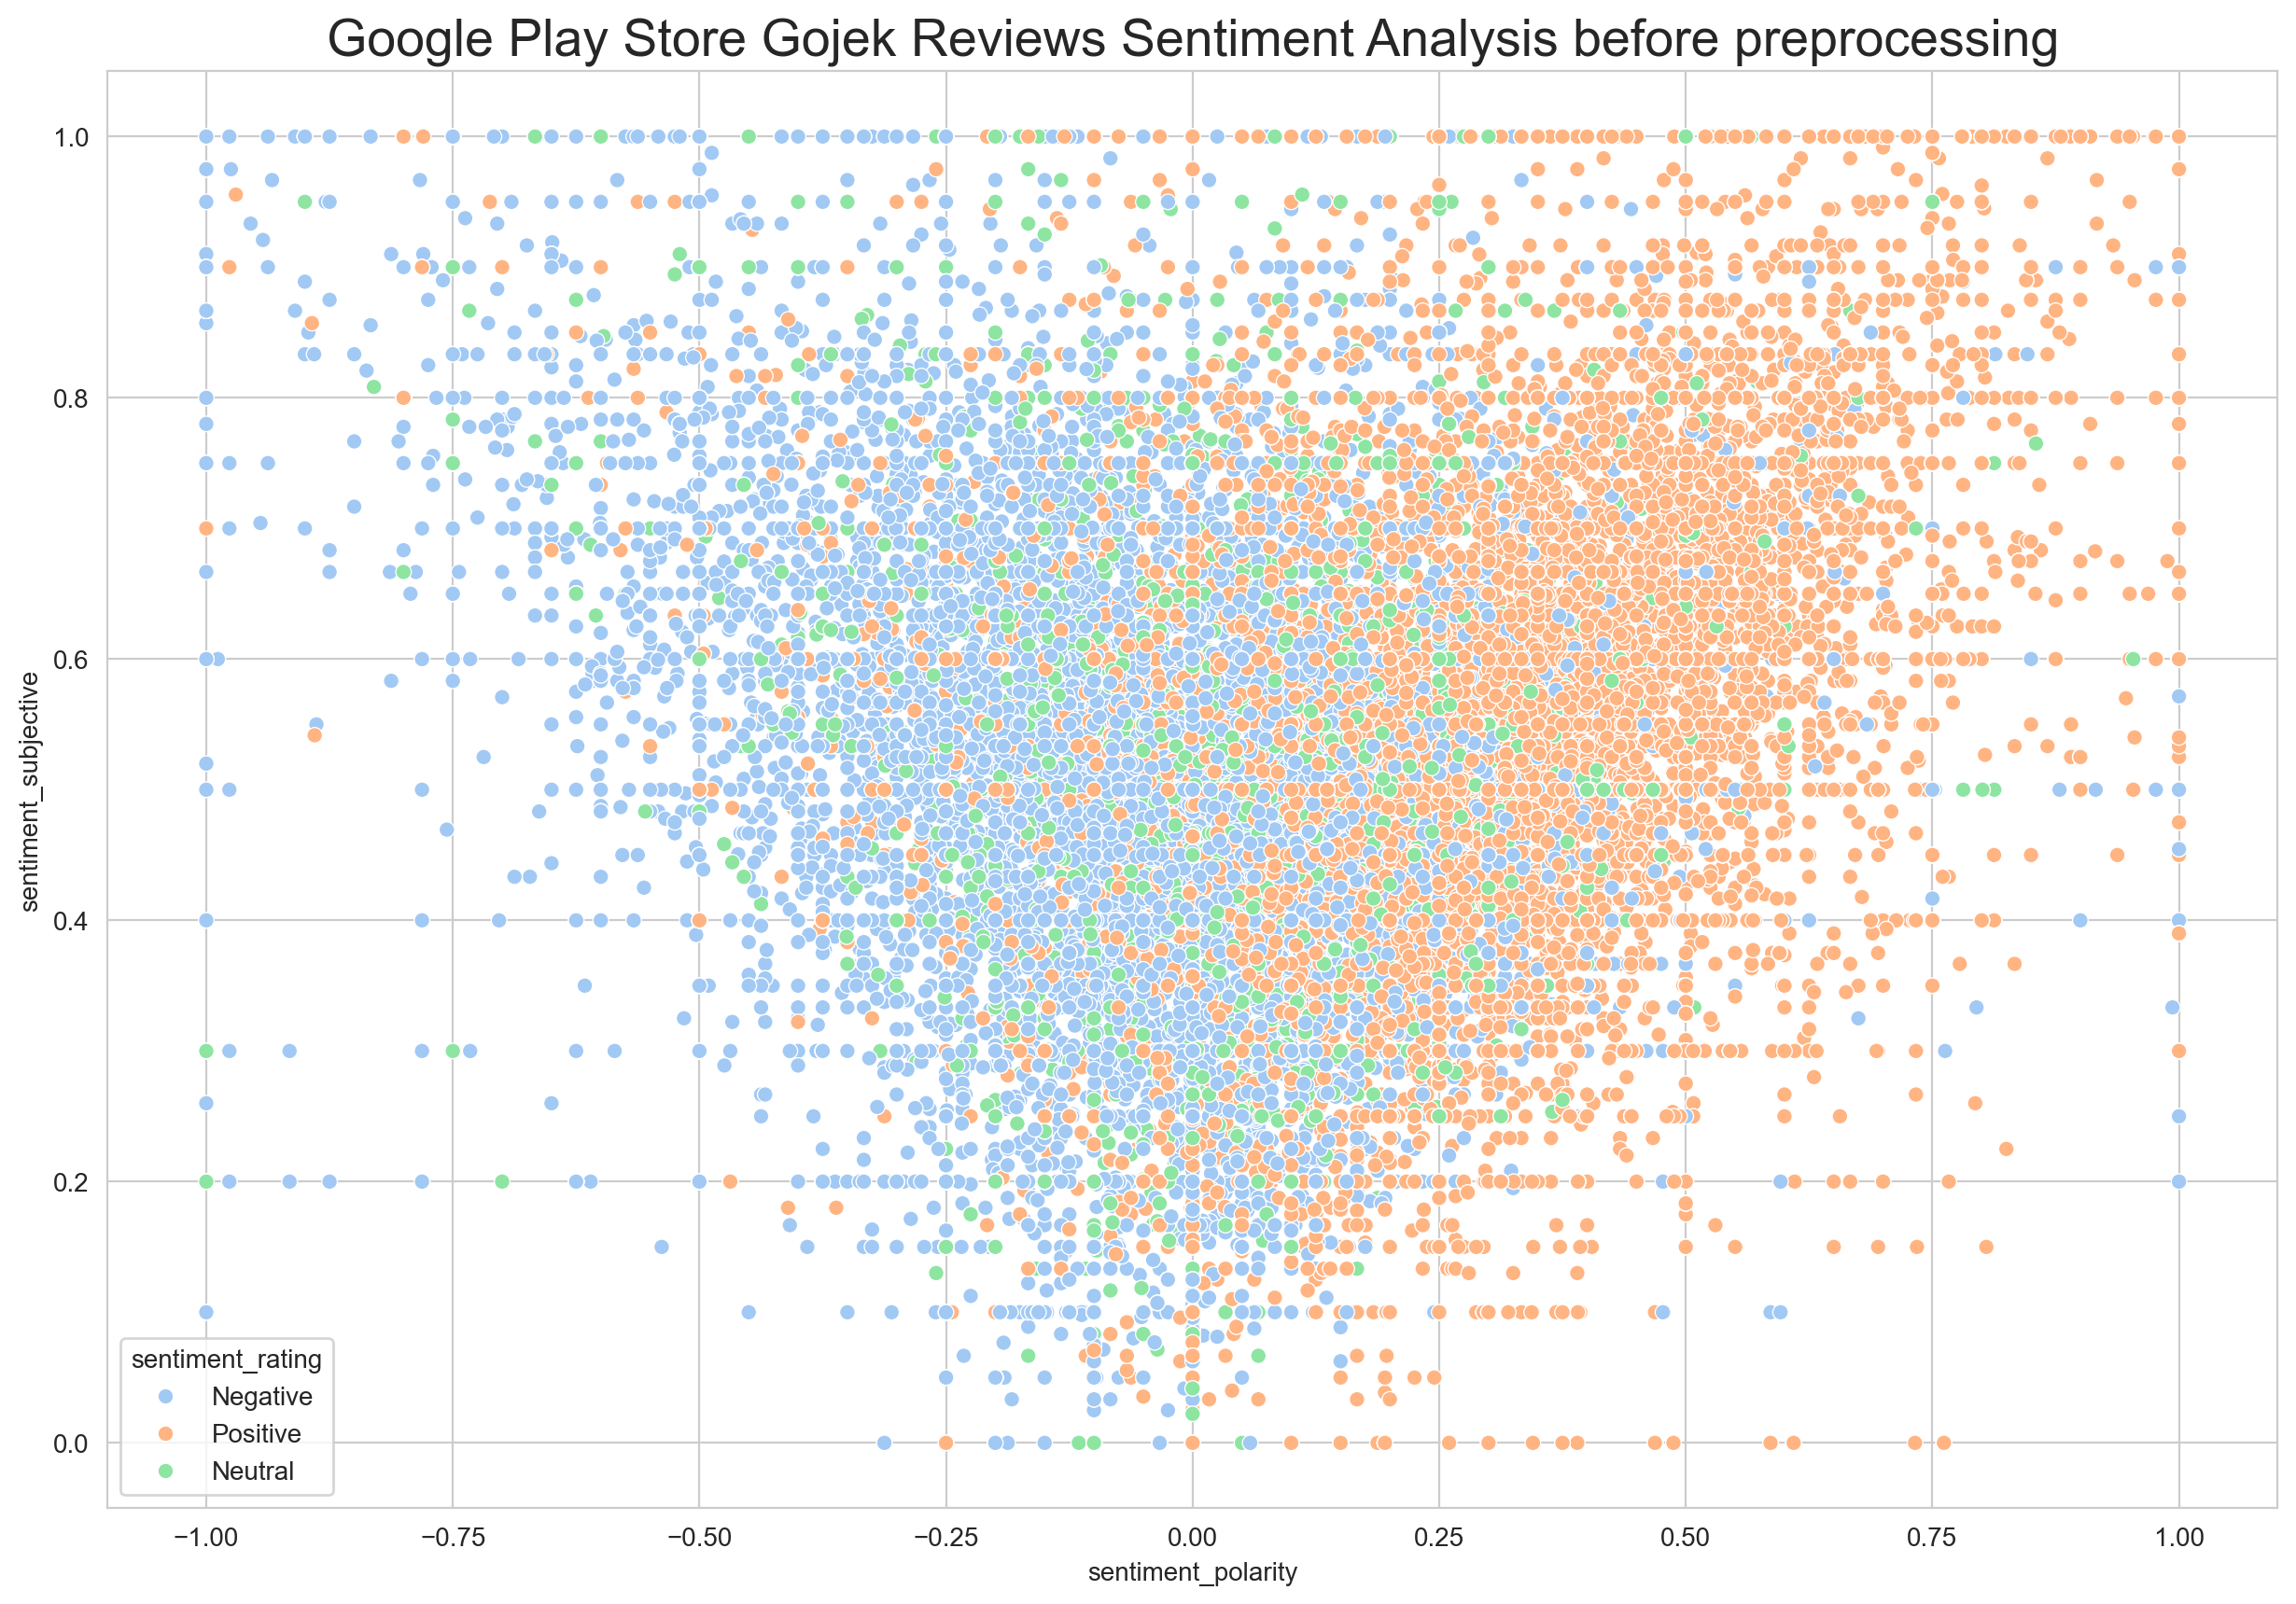

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_gjkrev['sentiment_polarity'], y=df_gjkrev['sentiment_subjective'],
                hue=df_gjkrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Gojek Reviews Sentiment Analysis before preprocessing", fontsize=20)
plt.show()

In [10]:
!pip install emoji


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

<h3>a. Lowercasing</h3>

In [12]:
# Lower casing
# Change the reviews type to string
df_gjkrev['content'] = df_gjkrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_gjkrev['content'][188])
print(df_gjkrev['content'][1])
print(df_gjkrev['content'][20100])

90% percent of food orders are WRONG AND MISSING FOOD...but drivers are really nice usually...the RESTAURANTS STAFFED BY PEOPLE WHO ARE MENTALLY HANDICAPPED
ok
slow and make my phone hang everytime make gojek order


In [13]:
#Lowercase all reviews to see the difference
df_gjkrev['content']= df_gjkrev['content'].apply(lambda x: x.lower())
print(df_gjkrev['content'][188])
print(df_gjkrev['content'][1])
print(df_gjkrev['content'][20100])

90% percent of food orders are wrong and missing food...but drivers are really nice usually...the restaurants staffed by people who are mentally handicapped
ok
slow and make my phone hang everytime make gojek order


In [14]:
df_gjkrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

content  \
0       update review 22 sept 2025 : paska udpate malah stuck ga bisa buka gofood gegara pop-up : "we are experiencing high traffic" terus. aaaa..... please fix it   
1                                                                                                                                                                ok   
2                                                                   route yg dipilih dibuat jauh dan muter muter, sehingga selisih harga bisa sampai 10rb lbh mahal   
3        bug: audio become mono upon answering the driver's call. force stopping the gojek process fixed the issue. the sound used was fired from wireless earbuds.   
4                                                                                                                                             terbantu terima kasih   
...                                                                                                                                                             ...   
226164                                                                                                                                                love this app   
226165                                                                                                                                        akhirnya keluar juga!   
226166                                                                                                                                                      finally   
226167                                                                                                                                                      helpful   
226168                                                                                                                                               usefull banget   

        score  sentiment_polarity  sentiment_subjective  
0           1                0.16                  0.54  
1           5                0.50                  0.50  
2           2                0.00                  0.00  
3           1                0.25                  0.30  
4           5                0.00                  0.00  
...       ...                 ...                   ...  
226164      5                0.50                  0.60  
226165      5                0.00                  0.00  
226166      5                0.00                  1.00  
226167      4                0.00                  0.00  
226168      5                0.00                  0.00  

[226169 rows x 4 columns]

<h3>b. Stopwords Removal</h3>

In [15]:
!pip install Sastrawi


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')

# Display first 20 stopwords
print(indonesian_stopwords[:20])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...


['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


[nltk_data]   Package stopwords is already up-to-date!


In [17]:
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

df_gjkrev['wordCount'] = [len(review.split()) for review in df_gjkrev['content']]
df_gjkrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_gjkrev['content']]
df_gjkrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_gjkrev['content']]

In [18]:
# Assuming the text column is named 'text', update accordingly
text_column = 'content'  # Change this if the column has a different name

# Combine all text data into one string
all_text = ' '.join(df_gjkrev[text_column].dropna().astype(str))

# Tokenize words and remove stopwords
words = all_text.split()
filtered_words = [word.lower() for word in words if word.lower() not in indonesian_stopwords]

In [19]:
df_gjkrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

content  \
0       update review 22 sept 2025 : paska udpate malah stuck ga bisa buka gofood gegara pop-up : "we are experiencing high traffic" terus. aaaa..... please fix it   
1                                                                                                                                                                ok   
2                                                                   route yg dipilih dibuat jauh dan muter muter, sehingga selisih harga bisa sampai 10rb lbh mahal   
3        bug: audio become mono upon answering the driver's call. force stopping the gojek process fixed the issue. the sound used was fired from wireless earbuds.   
4                                                                                                                                             terbantu terima kasih   
...                                                                                                                                                             ...   
226164                                                                                                                                                love this app   
226165                                                                                                                                        akhirnya keluar juga!   
226166                                                                                                                                                      finally   
226167                                                                                                                                                      helpful   
226168                                                                                                                                               usefull banget   

        score  sentiment_polarity  sentiment_subjective  wordCount  \
0           1                0.16                  0.54         27   
1           5                0.50                  0.50          1   
2           2                0.00                  0.00         16   
3           1                0.25                  0.30         25   
4           5                0.00                  0.00          3   
...       ...                 ...                   ...        ...   
226164      5                0.50                  0.60          3   
226165      5                0.00                  0.00          3   
226166      5                0.00                  1.00          1   
226167      4                0.00                  0.00          1   
226168      5                0.00                  0.00          2   

        uppercaseCharCount  specialCharCount  
0                        0                11  
1                        0                 0  
2                        0                 1  
3                        0                 5  
4                        0                 0  
...                    ...               ...  
226164                   0                 0  
226165                   0                 1  
226166                   0                 0  
226167                   0                 0  
226168                   0                 0  

[226169 rows x 7 columns]

In [20]:
# Indonesian Stopword Removal using Sastrawi
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Create stopword remover
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

sastrawi_stopwords = factory.get_stop_words()
print(f"There's total {len(sastrawi_stopwords)} Indonesian stopwords removed.")

There's total 126 Indonesian stopwords removed.


In [21]:
# English Stopword Removal using NLTK
# Get English stopwords
import nltk
nltk.download('stopwords')
english_stopwords = stopwords.words('english')

# To get the number of English stopwords, use the len() function:
print(f"There's total {len(english_stopwords)} English stopwords removed.")


There's total 198 English stopwords removed.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# Apply stopword removal to the 'content' column
df_gjkrev['content'] = df_gjkrev['content'].apply(lambda x: stopword_remover.remove(x))

<h3>c. Cleaning Text</h3>
(Include Stemming and Lemmatize)

In [23]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


# Create stemmer and lemmatizer objects
factory = StemmerFactory()
stemmer = factory.create_stemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [24]:
def cleaning_text(text):
  # Menambah spasi setelah koma pada koma yang tidak diberi spasi
  text = re.sub(r",(?!\s)", ", ", text)
  # menghapus special character
  text = re.sub(r'[^\w\s]', ' ', text)
  # Menghapus tab, new line, back slice, dll
  text = text.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace('\\', "")
  # Menghapus karakter non ASCII (emoticon, chinese word, dll),
  text = text.encode('ascii', 'replace').decode('ascii')
  # Menghapus URL
  text = re.sub(r"(?i)(?:https?:\/\/)?(?:www\.)?(?:[a-zA-Z0-9-.]+)(?:\.[a-zA-Z]{2,6})(?:\/[^\s\r\n]*)?", "", text)
  # Menghapus angka
  text = re.sub(r"\d+", "", text)
  # Menghapus tanda baca
  text = text.translate(str.maketrans("", "", string.punctuation))
  # Menghapus whitespace di depan/belakang teks dan double++ spasi
  text = text.strip()
  text = re.sub('\s+', ' ', text)
  # Menghapus single character
  text = re.sub(r"\b[a-zA-Z]\b", "", text)
  # stemming
  text = stemmer.stem(text)
  # lemmatize
  words = text.split()
  lemmatized_words = [lemmatizer.lemmatize(word, 'v') for word in words]
  text = ' '.join(lemmatized_words)
  return text

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\VICTUS\AppData\Local\Temp\ipykernel_22228\992346851.py:18: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [25]:
df_gjkrev.loc[:, 'clean'] = df_gjkrev['content'].apply(cleaning_text)

# Display the first few rows of the DataFrame with the cleaned reviews
print("DataFrame with cleaned reviews (first 5 rows):")
display(df_gjkrev[['content', 'clean']].head())

DataFrame with cleaned reviews (first 5 rows):


content  \
0      update review 22 sept 2025 : paska udpate malah stuck ga buka gofood gegara pop-up : "we are experiencing high traffic" terus. aaaa..... please fix it   
1                                                                                                                                                               
2                                                                               route yg dipilih dibuat jauh muter muter, selisih harga sampai 10rb lbh mahal   
3  bug: audio become mono upon answering the driver's call. force stopping the gojek process fixed the issue. the sound used was fired from wireless earbuds.   
4                                                                                                                                       terbantu terima kasih   

                                                                                                                                      clean  
0           update review sept paska udpate malah stick ga buka gofood gegara pop up we be experience high traffic terus aaaa please fix it  
1                                                                                                                                            
2                                                                    route yg pilih buat jauh muter muter selisih harga sampai rb lbh mahal  
3  bug audio become mono upon answer the driver call force stop the gojek process fix the issue the sound use be fire from wireless earbuds  
4                                                                                                                        bantu terima kasih

<h2>#3 Hasil Review</h2>

<h3>a. Frequency Words</h3>

Word  Frequency
0      the      35214
1     good      29563
2       to      28108
3   driver      26737
4    gojek      24815
..     ...        ...
95     was       2983
96   harga       2923
97      or       2907
98    from       2906
99     get       2895

[100 rows x 2 columns]

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_22228\856327870.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


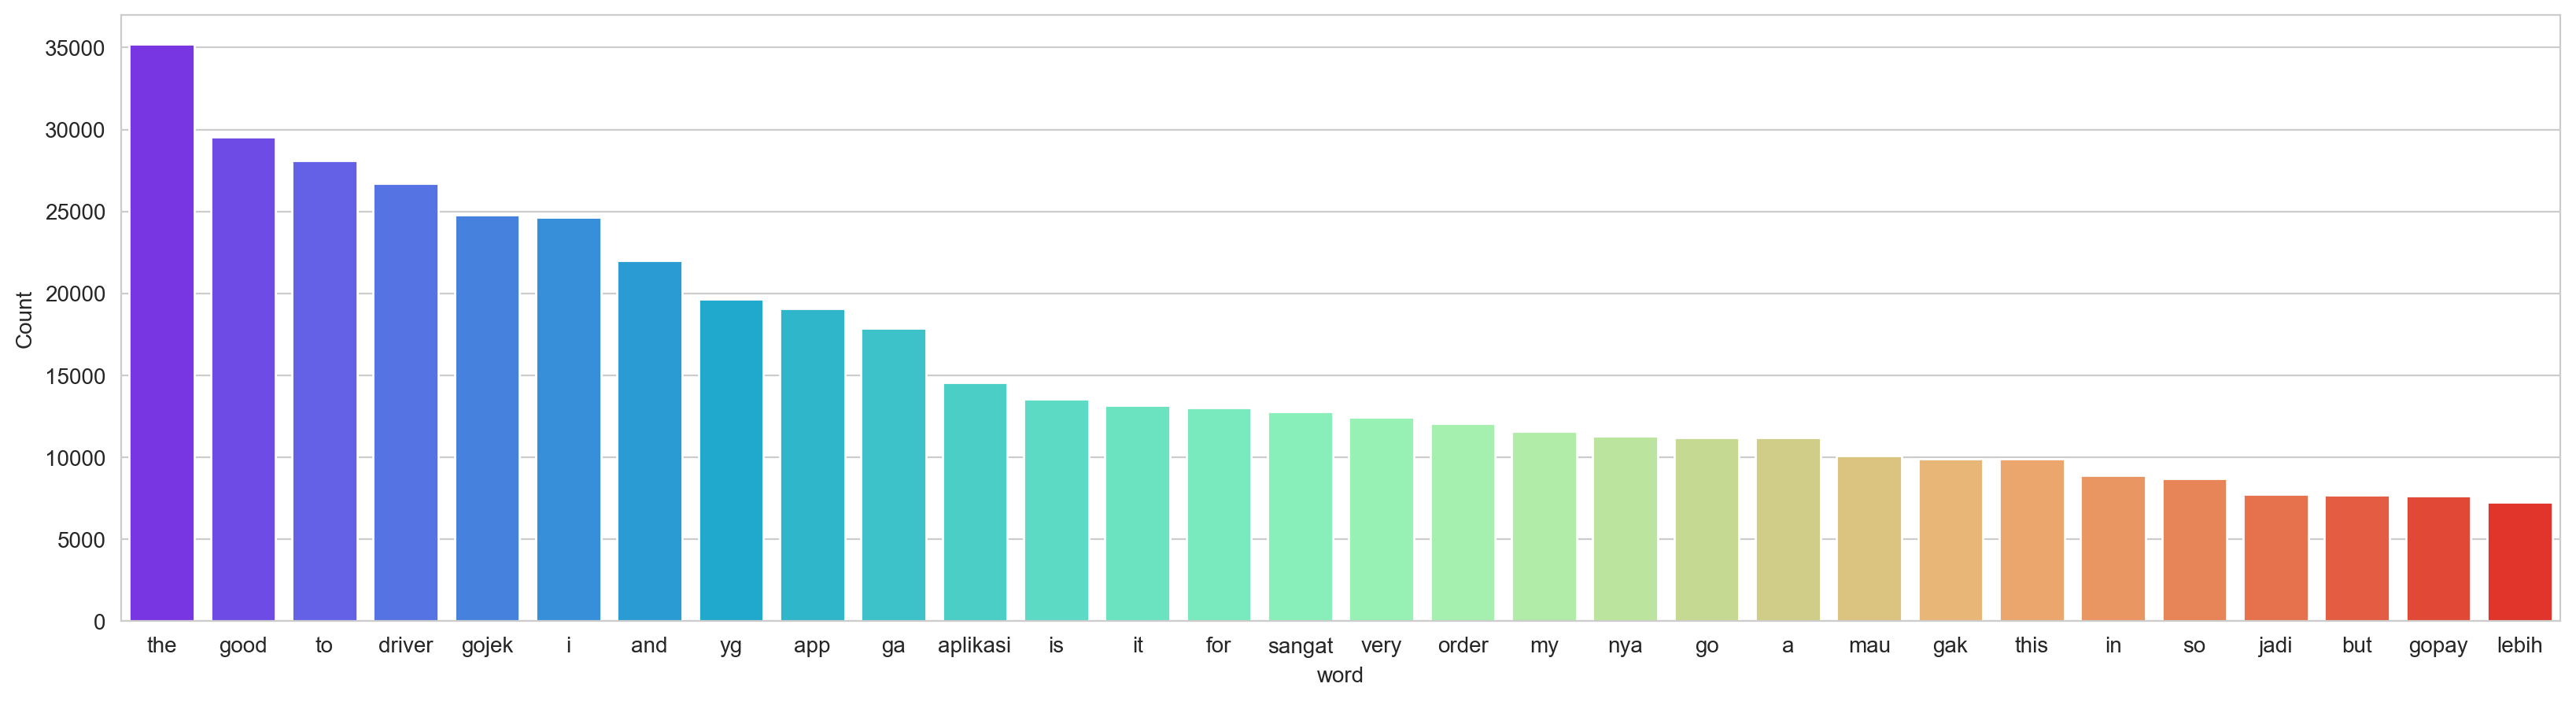

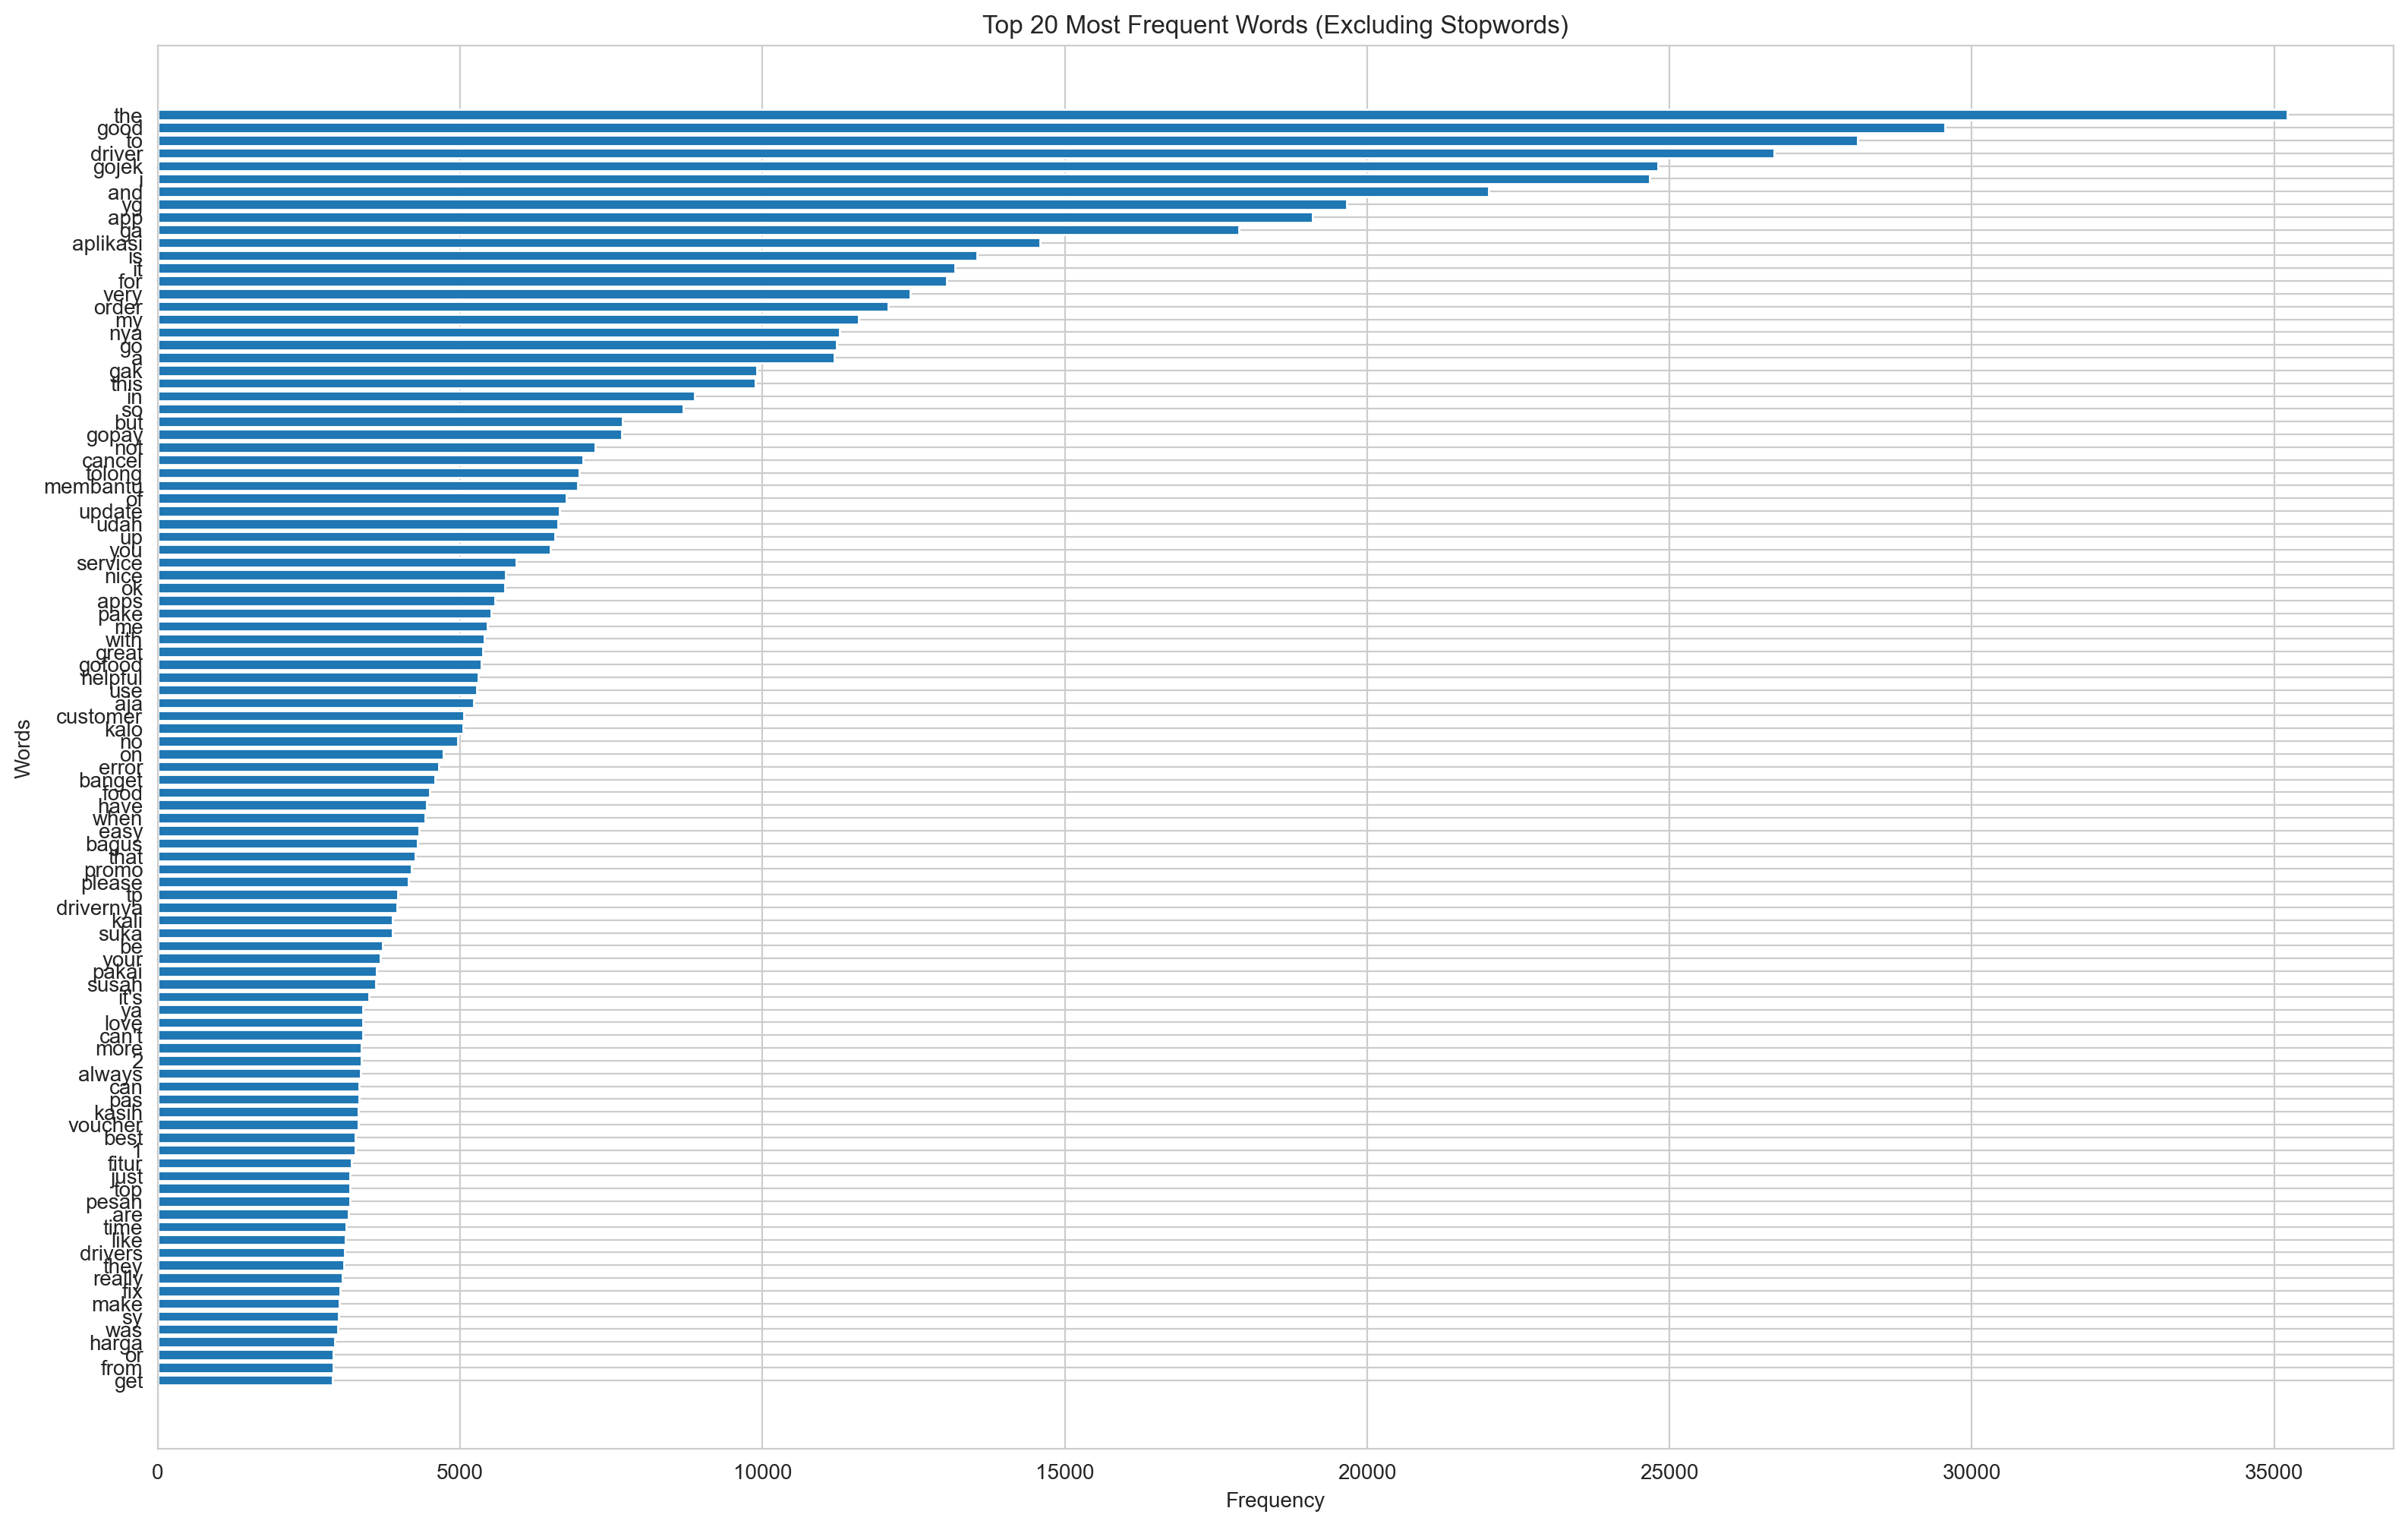

In [26]:
# Count frequent words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(100)

# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
display(word_freq_df)

# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

# Plot the frequent words
freq_words(df_gjkrev['content'])
plt.figure(figsize=(19, 12))
plt.barh(word_freq_df['Word'][::-1], word_freq_df['Frequency'][::-1])
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words (Excluding Stopwords)")
plt.show()

<h3>c. Sentiment Analysis after Preprocessing</h3>

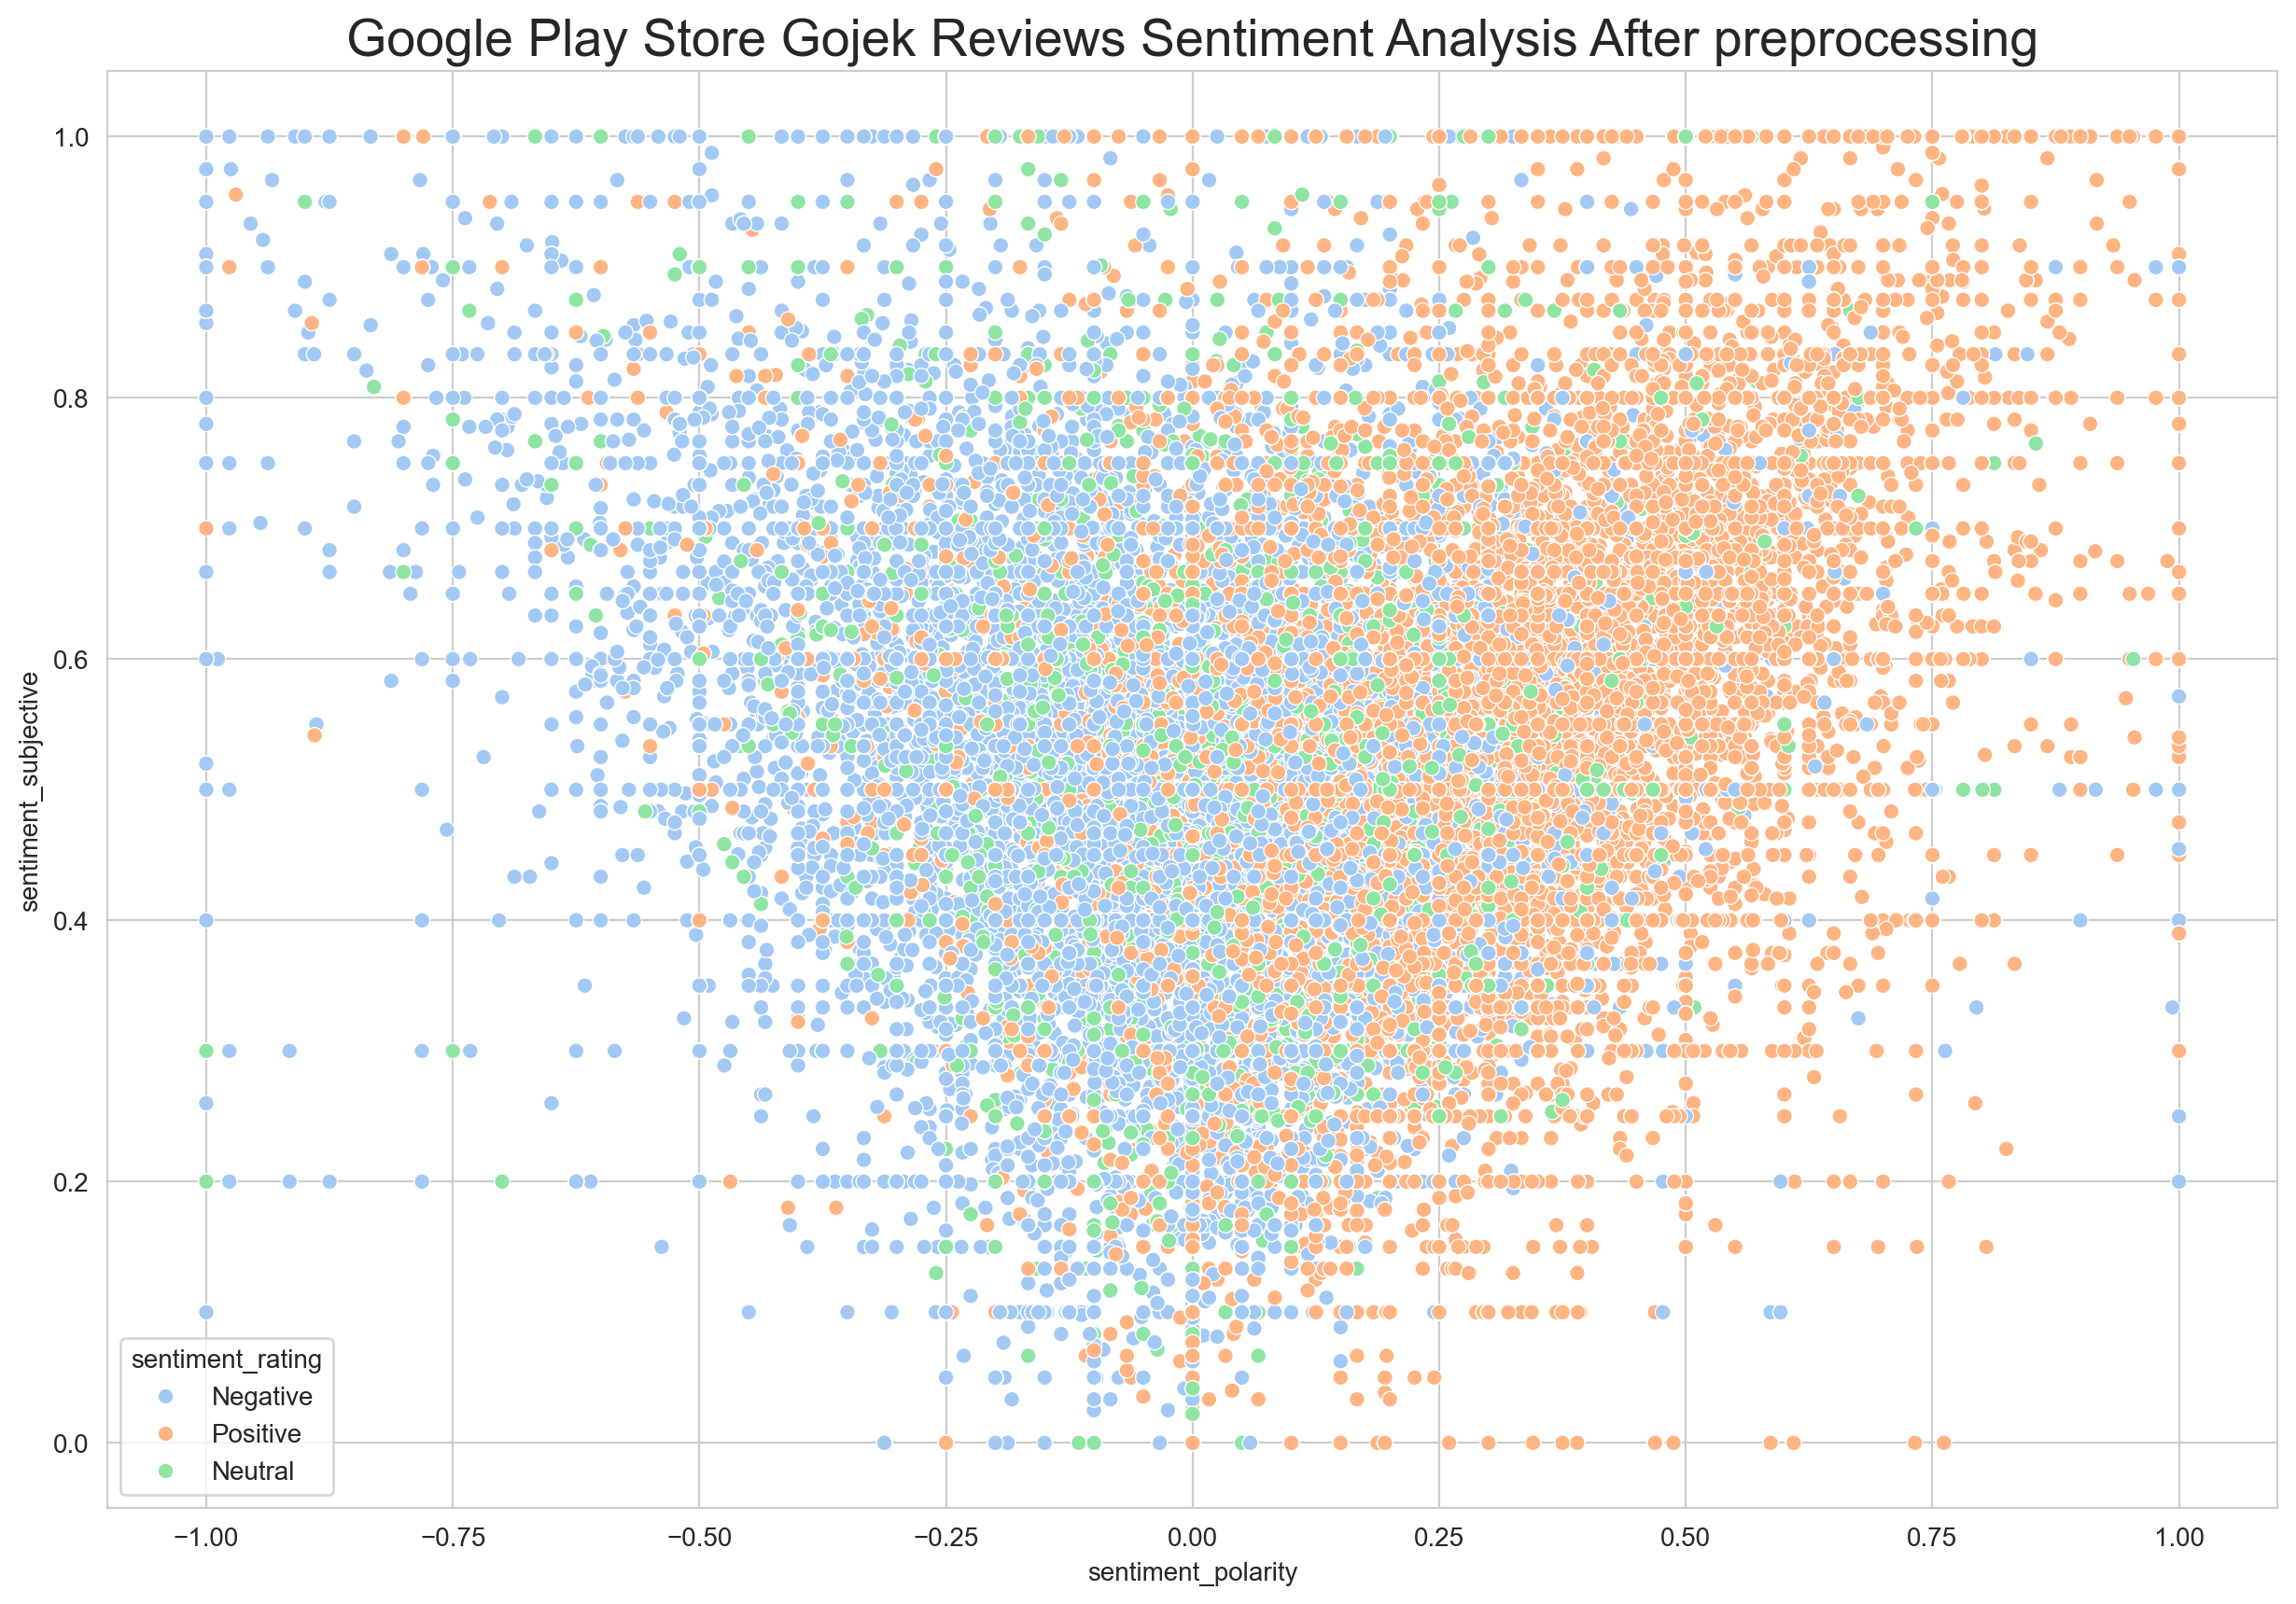

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_gjkrev['sentiment_polarity'], y=df_gjkrev['sentiment_subjective'],
                hue=df_gjkrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Gojek Reviews Sentiment Analysis After preprocessing", fontsize=20)
plt.show()

In [28]:
# Save the cleaned DataFrame to a new CSV file
df_gjkrev.to_csv(r'data/df_gjkrev_clean.csv', index=False)

<h3>d. TF-IDF</h3>

In [1]:
!pip install tensorflow -q
!pip install tensorflow_hub -q
!pip install torch
!pip install xgboost -q


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

c:\Users\VICTUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [11]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [12]:
df = pd.read_csv("data/df_gjkrev_clean.csv")
print("Dataset shape before:", df.shape)

# Keep only necessary columns
df = df[['content', 'score']].dropna()
print("Dataset shape after:", df.shape)
df.head()


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_1112\1413329488.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/df_gjkrev_clean.csv")


Dataset shape before: (226169, 18)
Dataset shape after: (221954, 2)


content  score
0  update review 22 sept 2025 : paska udpate mala...      1
2  route yg dipilih dibuat jauh muter muter, seli...      2
3  bug: audio become mono upon answering the driv...      1
4                              terbantu terima kasih      5
5                                              happy      5

In [13]:
# Label encoding: Convert scores to binary sentiment labels
def score_to_sentiment(score):
    if score <= 2:
        return 0   # negative
    elif score >= 4:
        return 1   # positive
    else:
        return None  # drop neutral

df['sentiment'] = df['score'].apply(score_to_sentiment)
df = df.dropna(subset=['sentiment'])
df['sentiment'] = df['sentiment'].astype(int)

print("Dataset shape after:", df.shape)
print(df['sentiment'].value_counts())

Dataset shape after: (206576, 3)
sentiment
1    141183
0     65393
Name: count, dtype: int64


In [14]:
# Split the dataset into training and testing sets
x = df['content']
y = df['sentiment']

xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
# Create a vocabulary
from collections import Counter
word_counts = Counter(' '.join(xtrain).split())

#Initial Classifiers

In [16]:
#Import libraries
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from timeit import default_timer as timer

#Initialize classifiers
svm_classifier = LinearSVC()
logistic_regression = LogisticRegression(max_iter=1000)
nb_classifier = MultinomialNB()
xgboost_classifier = XGBClassifier()
random_forest_classifier = RandomForestClassifier(n_estimators=100, max_depth=3, max_features='sqrt', min_samples_leaf=4, bootstrap=True, n_jobs=-1, random_state=0)

def evaluate_model(model, xtest, ytest):
    # Make predictions using the model
    y_pred = model.predict(xtest)

    # Calculate accuracy
    accuracy = accuracy_score(ytest, y_pred)
    # Calculate precision
    precision = precision_score(ytest, y_pred)
    # Calculate recall
    recall = recall_score(ytest, y_pred)
    # Calculate f1 score
    f1 = f1_score(ytest, y_pred)
    # Generate a classification report and confusion matrix
    report = classification_report(ytest, y_pred)
    cm = confusion_matrix(ytest, y_pred)
    return y_pred, accuracy, precision, recall, f1, report, cm

# Define batch size
batch_size = 1000


<h4>i. TF-IDF</h4>

In [23]:
from sklearn.feature_extraction.text import HashingVectorizer
from scipy import sparse
from scipy.sparse import csr_matrix, hstack

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_sparse_xtrain = tfidf_vectorizer.fit_transform(xtrain)   # csr_matrix, shape (n_train, n_features)
tfidf_sparse_xtest  = tfidf_vectorizer.transform(xtest)        # csr_matrix, shape (n_test,  n_features)

# Convert to dense only if memory allows
tfidf_vectorizer_xtrain = tfidf_sparse_xtrain
tfidf_vectorizer_xtest  = tfidf_sparse_xtest

In [24]:
#Fit Classifiers tfidf
svm_tfidf = svm_classifier.fit(tfidf_vectorizer_xtrain, ytrain)
lr_tfidf = logistic_regression.fit(tfidf_vectorizer_xtrain, ytrain)
nb_tfidf = nb_classifier.fit(tfidf_vectorizer_xtrain, ytrain)
xgboost_tfidf = xgboost_classifier.fit(tfidf_vectorizer_xtrain, ytrain)
rfc_tfidf = random_forest_classifier.fit(tfidf_vectorizer_xtrain, ytrain)

#Evaluate Model (Make predictions)

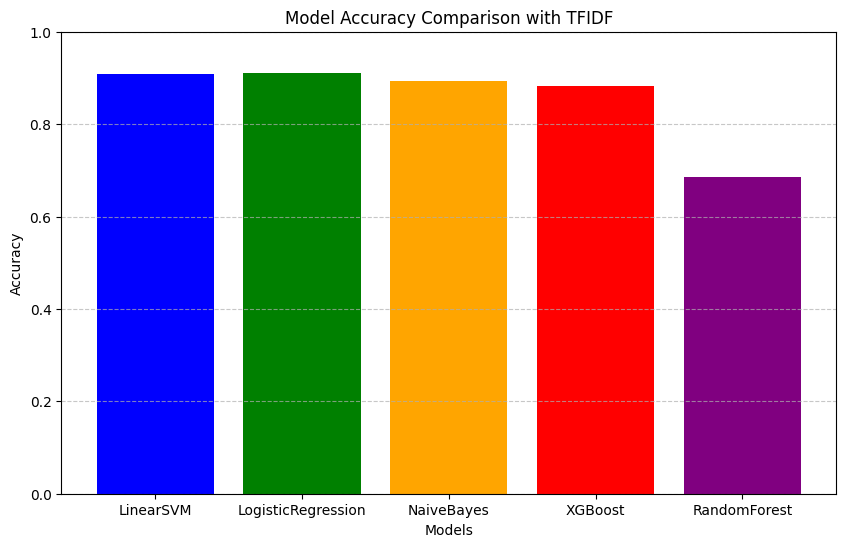

In [25]:
#Linear SVM 
y_pred_svm, accuracy_svm, precision_svm, recall_svm, f1_svm, report_svm, confusion_matrix_svm = evaluate_model(svm_tfidf, tfidf_vectorizer_xtest, ytest)

# Logistic Regression
y_pred_lr, accuracy_lr, precision_lr, recall_lr, f1_lr, report_lr, cm_lr = evaluate_model(lr_tfidf, tfidf_vectorizer_xtest, ytest)

#Naive Bayes
y_pred_nb, accuracy_nb, precision_nb, recall_nb, f1_nb, report_nb, cm_nb = evaluate_model(nb_tfidf, tfidf_vectorizer_xtest, ytest)

#XGBoost
y_pred_xgboost, accuracy_xgboost, precision_xgboost, recall_xgboost, f1_xgboost, report_xgboost, cm_xgboost = evaluate_model(xgboost_tfidf, tfidf_vectorizer_xtest, ytest)

#Random Forest
y_pred_rfc, accuracy_rfc, precision_rfc, recall_rfc, f1_rfc, report_rfc, cm_rfc = evaluate_model(rfc_tfidf, tfidf_vectorizer_xtest, ytest)

model_names = ['LinearSVM', 'LogisticRegression', 'NaiveBayes', 'XGBoost', 'RandomForest']
model_accuracies = [accuracy_svm, accuracy_lr, accuracy_nb, accuracy_xgboost, accuracy_rfc]

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison with TFIDF")
plt.ylim(0.0, 1.0)  # Set the y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<h4>ii. Universal Sentence Encoder (USE)</h4>

In [27]:
#Load the Universal Sentence Encoder model, and embed this model
embed = hub.load("https://kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow1/variations/universal-sentence-encoder/versions/1")

In [28]:
xtrain_use = []
xtest_use = []

for i in range(0, len(xtrain), batch_size):
    batch_X_train = xtrain[i:i + batch_size]
    batch_X_train_use = np.array(embed(batch_X_train))
    xtrain_use.extend(batch_X_train_use)

for i in range(0, len(xtest), batch_size):
    batch_X_test = xtest[i:i + batch_size]
    batch_X_test_use = np.array(embed(batch_X_test))
    xtest_use.extend(batch_X_test_use)

TypeError: 'AutoTrackable' object is not callable

In [ ]:
#Fit Classifiers
svm_use = svm_classifier.fit(xtrain_use, ytrain)
lr_use = logistic_regression.fit(xtrain_use, ytrain)
xgboost_use = xgboost_classifier.fit(xtrain_use, ytrain)
rfc_use = random_forest_classifier.fit(xtrain_use, ytrain)

#Evaluate Model

In [ ]:
y_pred_svm_use, accuracy_svm_use, precision_svm_use, recall_svm_use, f1_svm_use, report_svm_use, cm_svm_use = evaluate_model(svm_use, xtest_use, ytest)
y_pred_lr_use, accuracy_lr_use, precision_lr_use, recall_lr_use, f1_lr_use, report_lr_use, cm_lr_use = evaluate_model(lr_use, xtest_use, ytest)
y_pred_xgboost_use, accuracy_xgboost_use, precision_xgboost_use, recall_xgboost_use, f1_xgboost_use, report_xgboost_use, cm_xgboost_use = evaluate_model(xgboost_use, xtest_use, ytest)
y_pred_rfc_use, accuracy_rfc_use, precision_rfc_use, recall_rfc_use, f1_rfc_use, report_rfc_use, cm_rfc_use = evaluate_model(rfc_use, xtest_use, ytest)

# (--Note: Naive bayes (MultinomialNB) model not used with USE embedding because it not able to resolve the issue of negative values)
model_names = ['LinearSVM', 'LogisticRegression', 'XGBoost', 'RandomForest']
model_accuracies = [accuracy_svm_use, accuracy_lr_use, accuracy_xgboost_use, accuracy_rfc_use]

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies, color=['blue', 'orange', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison with USE")
plt.ylim(0.0, 1.0)  # Set the y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<h4>iii. TF-IDF + USE</h4>

In [ ]:
#Combine TF-IDF and USE embeddings
xtrain_tfidf_use_combined = tf.concat([tfidf_vectorizer_xtrain, xtrain_use], axis=1)
xtest_tfidf_use_combined = tf.concat([tfidf_vectorizer_xtest, xtest_use], axis=1)

#Fit Classifiers
svm_tfidf_use = svm_classifier.fit(xtrain_tfidf_use_combined, ytrain)
lr_tfidf_use = logistic_regression.fit(xtrain_tfidf_use_combined, ytrain)
xgboost_tfidf_use = xgboost_classifier.fit(xtrain_tfidf_use_combined, ytrain)
rfc_tfidf_use = random_forest_classifier.fit(xtrain_tfidf_use_combined, ytrain)

#Evaluate Model

In [ ]:
y_pred_svm_tfidf_use, accuracy_svm_tfidf_use, precision_svm_tfidf_use, recall_svm_tfidf_use, f1_svm_tfidf_use, report_svm_tfidf_use, cm_svm_tfidf_use = evaluate_model(svm_tfidf_use, xtest_tfidf_use_combined, ytest)
y_pred_lr_tfidf_use, accuracy_lr_tfidf_use, precision_lr_tfidf_use, recall_lr_tfidf_use, f1_lr_tfidf_use, report_lr_tfidf_use, cm_lr_tfidf_use = evaluate_model(lr_tfidf_use, xtest_tfidf_use_combined, ytest)
y_pred_xgboost_tfidf_use, accuracy_xgboost_tfidf_use, precision_xgboost_tfidf_use, recall_xgboost_tfidf_use, f1_xgboost_tfidf_use, report_xgboost_tfidf_use, cm_xgboost_tfidf_use = evaluate_model(xgboost_tfidf_use, xtest_tfidf_use_combined, ytest)
y_pred_rfc_tfidf_use, accuracy_rfc_tfidf_use, precision_rfc_tfidf_use, recall_rfc_tfidf_use, f1_rfc_tfidf_use, report_rfc_tfidf_use, cm_rfc_tfidf_use = evaluate_model(rfc_tfidf_use, xtest_tfidf_use_combined, ytest)

In [ ]:
# Define the classifiers and their corresponding accuracies
classifiers = ["Linear SVM", "Logistic Regression", "XGBoost", "Random Forest"]
tfidf_accuracies = [accuracy_svm, accuracy_lr, accuracy_xgboost, accuracy_rfc]  # Replace with actual accuracy values
use_accuracies = [accuracy_svm_use, accuracy_lr_use, accuracy_xgboost_use, accuracy_rfc_use]  # Replace with actual accuracy values
tfidf_use_accuracies = [accuracy_svm_tfidf_use, accuracy_lr_tfidf_use, accuracy_xgb_tfidf_use, accuracy_rfc_tfidf_use]  # Replace with actual accuracy values

# Create an index for the x-axis
x = np.arange(len(classifiers))

# Set the width of the bars
bar_width = 0.25

# Create a grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, tfidf_accuracies, bar_width, label='TF-IDF', color='orange')
plt.bar(x, use_accuracies, bar_width, label='USE', color='purple')
plt.bar(x + bar_width, tfidf_use_accuracies, bar_width, label='TF-IDF+USE', color='red')

# Set labels, title, and legend
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracies with Different Embeddings')
plt.xticks(x, classifiers)
plt.ylim(0, 1.0)
plt.legend()

# Add accuracy values on top of the bars
for i in range(len(classifiers)):
    plt.text(x[i] - bar_width, tfidf_accuracies[i] + 0.02, f"{tfidf_accuracies[i]:.2f}", ha='center')
    plt.text(x[i], use_accuracies[i] + 0.02, f"{use_accuracies[i]:.2f}", ha='center')
    plt.text(x[i] + bar_width, tfidf_use_accuracies[i] + 0.02, f"{tfidf_use_accuracies[i]:.2f}", ha='center')


# Display the plot
plt.tight_layout()
plt.show()